<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B8_%C2%AB%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8%C2%BB_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка данных

In [ ]:
path="https://d36tnp772eyphs.cloudfront.net/blogs/1/2020/04/cross-fox.jpg"
rs=24
divider=8

In [ ]:
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
import skimage
import numpy as np
import pandas as pd
from pylab import rcParams
from mpl_toolkits import mplot3d
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.mplot3d import Axes3D
rcParams['figure.figsize'] = (12, 9)
import seaborn as sns
from skimage import io
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from google.colab.patches import cv2_imshow
import time
from PIL import Image
def draw_picture(image, title='', bgr=False):

  r,g,b = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB # Но у меня почему то все норм D:
  new_image = cv2.merge([r, g, b])
  plt.figure(figsize=(7, 5))
  plt.axis('off')
  plt.imshow(new_image)

  plt.title(title)
  plt.show()

def recreate_image(codebook, labels, w, h):
  """Recreate the (compressed) image from the code book & labels"""
  return codebook[labels].reshape(w, h, -1)

[[107 110 117]
 [109 112 119]
 [111 114 121]
 ...
 [ 75  89  98]
 [ 73  90  98]
 [ 73  90  98]]
(160, 158, 3)
w: 160  h: 158  d: 3
474
75840


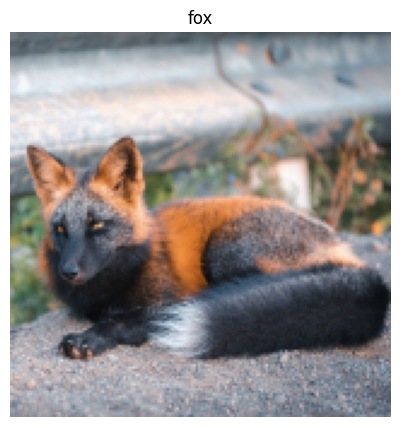

In [ ]:

s_img = io.imread(path)
wo,ho,do=so_shape=tuple(s_img.shape)
print(s_img[0]) #Чтобы представлять, что там вообще содержится
img = cv2.resize(s_img, (wo // divider,ho // divider), interpolation = cv2.INTER_AREA)

print(img.shape) # Y, X, число каналов
w, h, d = original_shape = tuple(img.shape)
print("w:",w," h:",h," d:",d)
image_array = np.reshape(img, (w * h, d))
print(img[0].size) # Y * channels
print(img.size) # X*y*channels
#cv2_imshow( img)
draw_picture(img,'fox')

#Кластеризация

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

In [ ]:
def draw_3d_colors(r,g,b):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  r = r.flatten()
  g = g.flatten()
  b = b.flatten()#plotting
  ax.scatter(r, g, b)
  plt.show()

In [ ]:
def get_descr(algo_name, img,target ,clusters=None):
  #data_range=img.max() - img.min()
    add_data=''
    if (algo_name=="KMeans" or algo_name=="AgglomerativeClustering"):
      add_data='(Clusters:'+str(clusters)+')'
    ss=ssim(img, target,channel_axis=2)
    return "{}\nSSIM {}".format(
        algo_name+add_data,
        ss
    )

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [ ]:
algorithms = [
    KMeans(n_clusters=2,random_state=rs),
    KMeans(n_clusters=5,random_state=rs),
    KMeans(n_clusters=10,random_state=rs),
    KMeans(n_clusters=20,random_state=rs),
    DBSCAN(eps=3, min_samples=4 ,leaf_size=100),
    AgglomerativeClustering(n_clusters=2),
    AgglomerativeClustering(n_clusters=5),
    AgglomerativeClustering(n_clusters=10),
    AgglomerativeClustering(n_clusters=20),
]
#algorithms = [
#    KMeans(n_clusters=2, random_state=rs)
#]


In [ ]:
def makeClusterCenterList(image,labels):

    centers=[]
    res_labels=np.reshape(labels, (-1, h))
    for a in set(labels):
        if (a!=-1):
          #print(a)
          temp=[]
          key=0
          for row in res_labels:
            x=0
            for item in row:

              if (a!=-1 and item==a):
                temp.append(image[key][x])
              x+=1
            key+=1
          x = np.mean(temp, axis=0).tolist()
          #print(x)
          centers.append(x)

    return centers

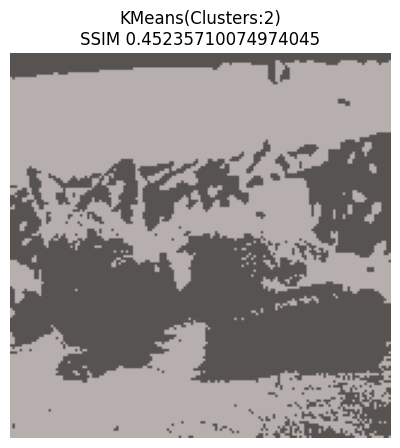

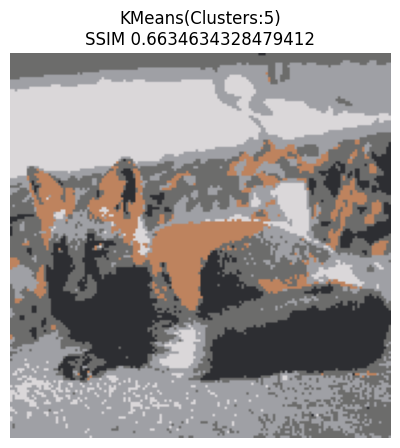

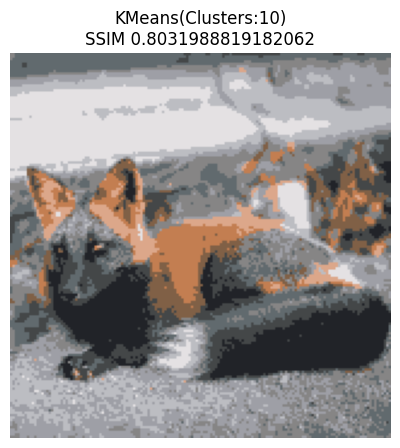

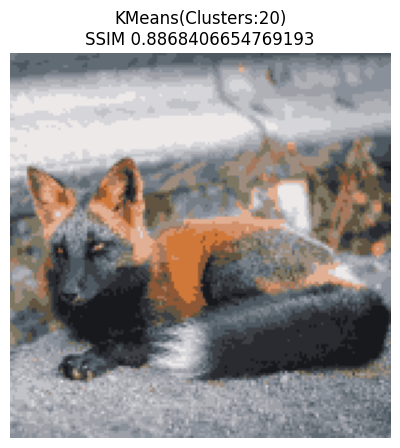

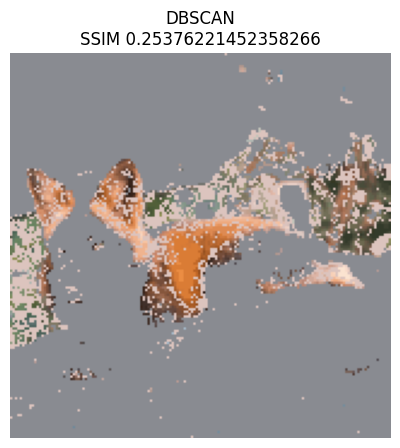

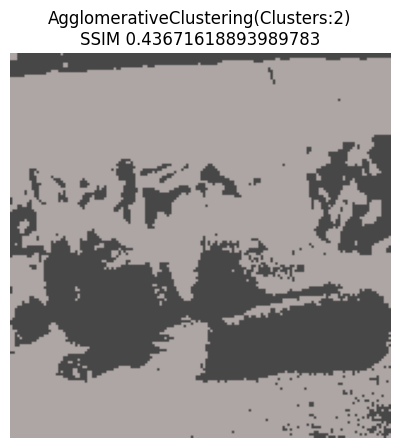

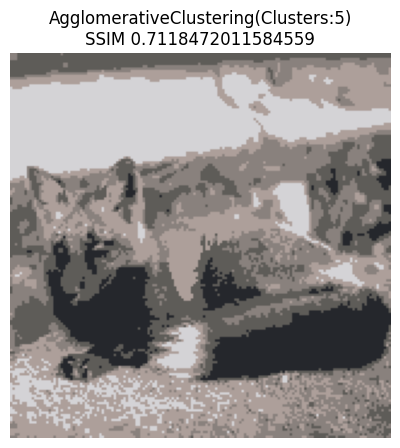

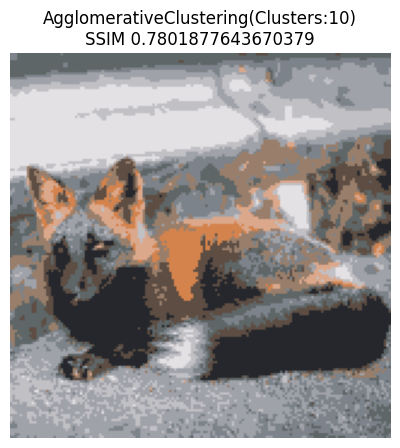

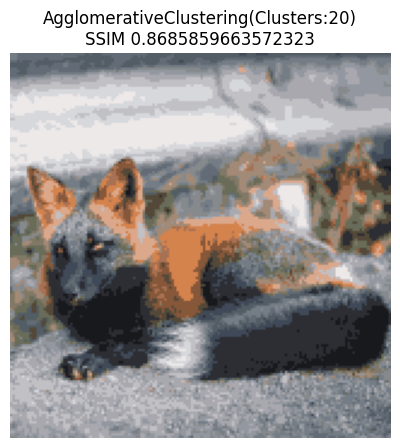

In [ ]:
results=[]
for ax, algorithm in zip(image_array,algorithms):
    csize=''
    # кластеризуем и выводим картинку
    st = time.time()
    labels= algorithm.fit_predict(image_array)

    if algorithm.__class__.__name__ in {'DBSCAN'}:

      res_labels=np.reshape(labels, (-1, h))

      centers=makeClusterCenterList(img,labels)

    csize=np.unique(algorithm.labels_).size
    if algorithm.__class__.__name__ in {'KMeans'}:
      centers=algorithm.cluster_centers_

    if algorithm.__class__.__name__ in {'AgglomerativeClustering'}:
      centers=makeClusterCenterList(img,labels)

    rec_img=recreate_image(np.rint(centers).astype(np.int32),labels, w, h)
    et= time.time()
    draw_picture(rec_img ,get_descr(algorithm.__class__.__name__,img,rec_img,csize))

    results.append([algorithm.__class__.__name__,csize,ssim(img, rec_img,channel_axis=2),(et-st)])

    # если есть центры кластеров - выведем их
 #   if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
 #        centers = algorithm.cluster_centers_
 #        plt.scatter(centers[:, 0], centers[:, 1], s=50)

#Вывод

Наилучший результат показал KMeans с 20 кластерами.
DBScan показала плохой результат по SSIM и по времени.
Kmeans показывает достаточно оптимальный результат по SSIM и времени при сжатии цвета.

In [ ]:
DataFrame(results, columns=["Class","Clusters","SSIM","Time"])

,Class,Clusters,SSIM,Time
0,KMeans,2,0.452357,0.597511
1,KMeans,5,0.663463,0.818031
2,KMeans,10,0.803199,1.666191
3,KMeans,20,0.886841,2.102231
4,DBSCAN,305,0.253762,2.269322
5,AgglomerativeClustering,2,0.436716,41.400626
6,AgglomerativeClustering,5,0.711847,37.642923
7,AgglomerativeClustering,10,0.780188,38.803754
8,AgglomerativeClustering,20,0.868586,39.450001
